## 군집화

In [15]:
# 데이터를 분석하는데 필요한 패키지 로드하기 
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
plt.rcParams.update({'font.family' : 'Malgun Gothic'}) 
pd.set_option('display.float_format', '{:,.2f}'.format)

# 데이터 불러오기
raw_df1 = pd.read_csv('Data1_전처리및212223인구.csv', encoding='UTF-8') ## 인코딩 설정하지 않으면 에러 발생
raw_df2 = pd.read_csv('Data2_전처리.csv', encoding='UTF-8') 
raw_df3 = pd.read_csv('Data3_전처리.csv', encoding='UTF-8') 
raw_df3_plus = pd.read_csv('Data3_증가분_전처리.csv', encoding='UTF-8') 

# 복사본 만들기 
df1 = raw_df1.copy()
df2 = raw_df2.copy()
df3 = raw_df3.copy()
df3_plus = raw_df3_plus.copy()

In [16]:
df1.head()

,기준연도,시군명,연령대,성별,결제건수,결제금액,결제취소건수,결제취소금액,1회평균결제금액,총인구,총인구_남,총인구_여,내국인_세대수,내국인_총인구,내국인_남,내국인_여,등록외국인_총인구,등록외국인_남,등록외국인_여,관광객수
0,2023,가평군,10대,남,8409,"18,884.51",46.00,487.18,2.25,"63,488.00","32,650.00","30,838.00","32,606.00","62,302.00","32,137.00","30,165.00","1,186.00",513.00,673.00,"26,926,952.00"
1,2023,가평군,10대,여,6584,"17,660.54",68.00,184.14,2.68,"63,488.00","32,650.00","30,838.00","32,606.00","62,302.00","32,137.00","30,165.00","1,186.00",513.00,673.00,"26,926,952.00"
2,2023,가평군,20대,남,70363,"154,501.83",728.00,"3,756.00",2.20,"63,488.00","32,650.00","30,838.00","32,606.00","62,302.00","32,137.00","30,165.00","1,186.00",513.00,673.00,"26,926,952.00"
3,2023,가평군,20대,여,55118,"133,250.66",681.00,"2,799.63",2.42,"63,488.00","32,650.00","30,838.00","32,606.00","62,302.00","32,137.00","30,165.00","1,186.00",513.00,673.00,"26,926,952.00"
4,2023,가평군,30대,남,110968,"268,223.50","1,382.00","8,447.63",2.42,"63,488.00","32,650.00","30,838.00","32,606.00","62,302.00","32,137.00","30,165.00","1,186.00",513.00,673.00,"26,926,952.00"


In [17]:
df2.head()

,시군명,기준년월,월별신규가입자수(명),월별충전액(만원),월별사용액(만원)
0,가평군,2023-12,484.00,"405,100.00","214,000.00"
1,가평군,2023-11,458.00,"236,800.00","218,700.00"
2,가평군,2023-10,555.00,"259,600.00","233,500.00"
3,가평군,2023-09,782.00,"311,300.00","237,600.00"
4,가평군,2023-08,473.00,"363,100.00","239,200.00"


In [18]:
df3.head()

,시군명,상호명,업종명,업종코드,휴폐업상태,폐업일자,데이터기준일자,업종명_카테고리
0,고양시,까망노래연습장,노래방,8402,계속사업자,NaN,20240331,오락 및 여가시설
1,고양시,일산좋은치과의원,치과,4201,계속사업자,NaN,20240331,병원 및 의료기관
2,고양시,잉크존,"문구,사무용품",8102,계속사업자,NaN,20240331,소매업
3,고양시,참좋은집,오양.보육.복지시설,7301,계속사업자,NaN,20240331,기타 의료 및 복지시설
4,고양시,(주)팩토리빈,커피전문점,2502,계속사업자,NaN,20240331,카페 및 베이커리


In [19]:
df3_plus.head()

,시군명,2024개수,2022개수,증가분
0,평택시,28535,20078,8457
1,수원시,37487,35465,2022
2,광명시,10594,8745,1849
3,양주시,9736,7895,1841
4,화성시,27663,26308,1355


In [20]:
# 인구통계 데이터를 이용한 파생변수 추가

# 빈 데이터프레임 생성
result_dfs = []

# 각 연도별로 반복
for year in [2023, 2022, 2021]:
    # 연도별 데이터 필터링
    year_df = df1[df1['기준연도'] == year]
    
    # 시군명 별로 데이터 그룹화
    grouped_df = year_df.groupby('시군명').agg({
        '결제건수': 'sum',
        '결제금액': 'sum',
        '결제취소건수' : 'sum',
        '결제취소금액' : 'sum',
        '총인구': 'mean',  # 총인구는 평균을 사용하여 시군별로 인구를 대체
        '등록외국인_총인구': 'mean',
        '관광객수' : 'mean'
    }).reset_index()

    # 외국인 비율 계산
    grouped_df['외국인 비율'] = grouped_df['등록외국인_총인구'] / grouped_df['총인구']
    
    # 관광객 비율 계산
    grouped_df['관광객 비율'] = grouped_df['관광객수'] / grouped_df['총인구']

    # 인구 대비 관광객 수 계산
    grouped_df['인구 대비 관광객 수'] = grouped_df['관광객수'] / (grouped_df['총인구'] + grouped_df['관광객수'])

    # 컬럼 이름 변경
    grouped_df = grouped_df.rename(columns={
        '결제건수': '총결제건수(연도별)',
        '결제금액': '총결제금액(연도별)',
        '결제취소건수' : '총결제취소건수(연도별)',
        '결제취소금액' : '총결제취소금액(연도별)'
    })

    # 결제건수 비율과 결제금액 비율 계산
    grouped_df['결제건수 비율'] = grouped_df['총결제건수(연도별)'] / grouped_df['총인구']
    grouped_df['결제금액 비율'] = grouped_df['총결제금액(연도별)'] / grouped_df['총인구']

    # 결제취소건수 비율과 결제취소금액 비율 계산
    grouped_df['결제취소건수 비율'] = grouped_df['총결제취소건수(연도별)'] / grouped_df['총인구']
    grouped_df['결제취소금액 비율'] = grouped_df['총결제취소금액(연도별)'] / grouped_df['총인구']

    # 연도 컬럼 추가
    grouped_df['기준연도'] = year
    
    # 결과 데이터프레임에 추가
    result_dfs.append(grouped_df)

# 모든 연도 데이터프레임 통합
final_df = pd.concat(result_dfs)

final_df

,시군명,총결제건수(연도별),총결제금액(연도별),총결제취소건수(연도별),총결제취소금액(연도별),총인구,등록외국인_총인구,관광객수,외국인 비율,관광객 비율,인구 대비 관광객 수,결제건수 비율,결제금액 비율,결제취소건수 비율,결제취소금액 비율,기준연도
0,가평군,1453718,"3,774,609.88","15,343.00","85,634.55","63,488.00","1,186.00","26,926,952.00",0.02,424.13,1.00,22.90,59.45,0.24,1.35,2023
1,고양시,6885890,"13,860,678.98","42,312.00","134,395.96","1,087,607.00","12,700.00","167,874,170.00",0.01,154.35,0.99,6.33,12.74,0.04,0.12,2023
2,과천시,1825774,"3,951,783.29","11,960.00","45,514.34","81,219.00",219.00,"20,476,628.00",0.00,252.12,1.00,22.48,48.66,0.15,0.56,2023
3,광명시,5959843,"14,699,869.58","44,758.00","277,752.07","283,124.00","2,927.00","40,908,151.00",0.01,144.49,0.99,21.05,51.92,0.16,0.98,2023
4,광주시,7775989,"19,407,576.76","80,774.00","491,951.30","404,270.00","12,893.00","46,240,850.00",0.03,114.38,0.99,19.23,48.01,0.20,1.22,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,의왕시,2453973,"5,012,366.05","21,401.00","96,355.58","164,363.00","1,007.00","25,917,420.00",0.01,157.68,0.99,14.93,30.50,0.13,0.59,2021
15,의정부시,6133934,"12,264,379.93","44,036.00","158,088.87","468,339.00","4,678.00","38,987,138.00",0.01,83.25,0.99,13.10,26.19,0.09,0.34,2021
16,파주시,7099954,"16,581,704.95","62,260.00","254,362.58","493,503.00","10,258.00","50,951,894.00",0.02,103.25,0.99,14.39,33.60,0.13,0.52,2021
17,포천시,2074278,"5,156,087.87","18,998.00","91,553.12","160,209.00","11,270.00","28,452,691.00",0.07,177.60,0.99,12.95,32.18,0.12,0.57,2021


In [21]:
# df1과 final_df를 '시군명'과 '기준연도'를 기준으로 병합
df1 = pd.merge(df1, final_df[['시군명', '기준연도', '총결제건수(연도별)', '총결제금액(연도별)', '외국인 비율', '결제건수 비율', '결제금액 비율', '관광객 비율', '인구 대비 관광객 수', '결제취소건수 비율', '결제취소금액 비율']], on=['시군명', '기준연도'], how='left')
df1

,기준연도,시군명,연령대,성별,결제건수,결제금액,결제취소건수,결제취소금액,1회평균결제금액,총인구,총인구_남,총인구_여,내국인_세대수,내국인_총인구,내국인_남,내국인_여,등록외국인_총인구,등록외국인_남,등록외국인_여,관광객수,총결제건수(연도별),총결제금액(연도별),외국인 비율,결제건수 비율,결제금액 비율,관광객 비율,인구 대비 관광객 수,결제취소건수 비율,결제취소금액 비율
0,2023,가평군,10대,남,8409,"18,884.51",46.00,487.18,2.25,"63,488.00","32,650.00","30,838.00","32,606.00","62,302.00","32,137.00","30,165.00","1,186.00",513.00,673.00,"26,926,952.00",1453718,"3,774,609.88",0.02,22.90,59.45,424.13,1.00,0.24,1.35
1,2023,가평군,10대,여,6584,"17,660.54",68.00,184.14,2.68,"63,488.00","32,650.00","30,838.00","32,606.00","62,302.00","32,137.00","30,165.00","1,186.00",513.00,673.00,"26,926,952.00",1453718,"3,774,609.88",0.02,22.90,59.45,424.13,1.00,0.24,1.35
2,2023,가평군,20대,남,70363,"154,501.83",728.00,"3,756.00",2.20,"63,488.00","32,650.00","30,838.00","32,606.00","62,302.00","32,137.00","30,165.00","1,186.00",513.00,673.00,"26,926,952.00",1453718,"3,774,609.88",0.02,22.90,59.45,424.13,1.00,0.24,1.35
3,2023,가평군,20대,여,55118,"133,250.66",681.00,"2,799.63",2.42,"63,488.00","32,650.00","30,838.00","32,606.00","62,302.00","32,137.00","30,165.00","1,186.00",513.00,673.00,"26,926,952.00",1453718,"3,774,609.88",0.02,22.90,59.45,424.13,1.00,0.24,1.35
4,2023,가평군,30대,남,110968,"268,223.50","1,382.00","8,447.63",2.42,"63,488.00","32,650.00","30,838.00","32,606.00","62,302.00","32,137.00","30,165.00","1,186.00",513.00,673.00,"26,926,952.00",1453718,"3,774,609.88",0.02,22.90,59.45,424.13,1.00,0.24,1.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1293,2021,화성시,60대,여,392006,"872,926.29","3,950.00","14,035.35",2.23,"922,092.00","485,329.00","436,763.00","372,888.00","887,015.00","460,788.00","426,227.00","35,077.00","24,541.00","10,536.00","90,629,181.00",17790643,"41,536,194.92",0.04,19.29,45.05,98.29,0.99,0.16,0.67
1294,2021,화성시,70대,남,93924,"201,672.86",878.00,"3,674.47",2.15,"922,092.00","485,329.00","436,763.00","372,888.00","887,015.00","460,788.00","426,227.00","35,077.00","24,541.00","10,536.00","90,629,181.00",17790643,"41,536,194.92",0.04,19.29,45.05,98.29,0.99,0.16,0.67
1295,2021,화성시,70대,여,94936,"211,313.70",948.00,"3,108.21",2.23,"922,092.00","485,329.00","436,763.00","372,888.00","887,015.00","460,788.00","426,227.00","35,077.00","24,541.00","10,536.00","90,629,181.00",17790643,"41,536,194.92",0.04,19.29,45.05,98.29,0.99,0.16,0.67
1296,2021,화성시,80대 이상,남,14820,"29,606.31",128.00,342.42,2.00,"922,092.00","485,329.00","436,763.00","372,888.00","887,015.00","460,788.00","426,227.00","35,077.00","24,541.00","10,536.00","90,629,181.00",17790643,"41,536,194.92",0.04,19.29,45.05,98.29,0.99,0.16,0.67


In [22]:
# 기준년월에서 기준연도 추출
df2['기준연도'] = df2['기준년월'].str[:4].astype(int)

In [23]:
상점수 = df3.groupby('시군명').size().reset_index(name='상점수')

# 시군명별 총 업종 개수 구하기
시군별_상점수 = 상점수.groupby('시군명')['상점수'].sum().reset_index()

df3_count = 시군별_상점수.sort_values(by = '시군명')
df3_count

,시군명,상점수
0,가평군,3354
1,고양시,26672
2,과천시,2032
3,광명시,10594
4,광주시,11204
5,구리시,6281
6,군포시,7370
7,김포시,14833
8,남양주시,20531
9,동두천시,3308


In [24]:
df3_plus

,시군명,2024개수,2022개수,증가분
0,평택시,28535,20078,8457
1,수원시,37487,35465,2022
2,광명시,10594,8745,1849
3,양주시,9736,7895,1841
4,화성시,27663,26308,1355
5,시흥시,14727,13375,1352
6,파주시,15986,14784,1202
7,용인시,27909,27146,763
8,안양시,16937,16178,759
9,과천시,2032,1469,563


In [25]:
# 데이터 병합 (시군명과 기준연도 기준)
merged_data = pd.merge(df1, df3_plus, on='시군명', how='inner')

In [26]:
pd.set_option('display.max_columns', None)
merged_data

,기준연도,시군명,연령대,성별,결제건수,결제금액,결제취소건수,결제취소금액,1회평균결제금액,총인구,총인구_남,총인구_여,내국인_세대수,내국인_총인구,내국인_남,내국인_여,등록외국인_총인구,등록외국인_남,등록외국인_여,관광객수,총결제건수(연도별),총결제금액(연도별),외국인 비율,결제건수 비율,결제금액 비율,관광객 비율,인구 대비 관광객 수,결제취소건수 비율,결제취소금액 비율,2024개수,2022개수,증가분
0,2023,가평군,10대,남,8409,"18,884.51",46.00,487.18,2.25,"63,488.00","32,650.00","30,838.00","32,606.00","62,302.00","32,137.00","30,165.00","1,186.00",513.00,673.00,"26,926,952.00",1453718,"3,774,609.88",0.02,22.90,59.45,424.13,1.00,0.24,1.35,3354,3553,-199
1,2023,가평군,10대,여,6584,"17,660.54",68.00,184.14,2.68,"63,488.00","32,650.00","30,838.00","32,606.00","62,302.00","32,137.00","30,165.00","1,186.00",513.00,673.00,"26,926,952.00",1453718,"3,774,609.88",0.02,22.90,59.45,424.13,1.00,0.24,1.35,3354,3553,-199
2,2023,가평군,20대,남,70363,"154,501.83",728.00,"3,756.00",2.20,"63,488.00","32,650.00","30,838.00","32,606.00","62,302.00","32,137.00","30,165.00","1,186.00",513.00,673.00,"26,926,952.00",1453718,"3,774,609.88",0.02,22.90,59.45,424.13,1.00,0.24,1.35,3354,3553,-199
3,2023,가평군,20대,여,55118,"133,250.66",681.00,"2,799.63",2.42,"63,488.00","32,650.00","30,838.00","32,606.00","62,302.00","32,137.00","30,165.00","1,186.00",513.00,673.00,"26,926,952.00",1453718,"3,774,609.88",0.02,22.90,59.45,424.13,1.00,0.24,1.35,3354,3553,-199
4,2023,가평군,30대,남,110968,"268,223.50","1,382.00","8,447.63",2.42,"63,488.00","32,650.00","30,838.00","32,606.00","62,302.00","32,137.00","30,165.00","1,186.00",513.00,673.00,"26,926,952.00",1453718,"3,774,609.88",0.02,22.90,59.45,424.13,1.00,0.24,1.35,3354,3553,-199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1293,2021,화성시,60대,여,392006,"872,926.29","3,950.00","14,035.35",2.23,"922,092.00","485,329.00","436,763.00","372,888.00","887,015.00","460,788.00","426,227.00","35,077.00","24,541.00","10,536.00","90,629,181.00",17790643,"41,536,194.92",0.04,19.29,45.05,98.29,0.99,0.16,0.67,27663,26308,1355
1294,2021,화성시,70대,남,93924,"201,672.86",878.00,"3,674.47",2.15,"922,092.00","485,329.00","436,763.00","372,888.00","887,015.00","460,788.00","426,227.00","35,077.00","24,541.00","10,536.00","90,629,181.00",17790643,"41,536,194.92",0.04,19.29,45.05,98.29,0.99,0.16,0.67,27663,26308,1355
1295,2021,화성시,70대,여,94936,"211,313.70",948.00,"3,108.21",2.23,"922,092.00","485,329.00","436,763.00","372,888.00","887,015.00","460,788.00","426,227.00","35,077.00","24,541.00","10,536.00","90,629,181.00",17790643,"41,536,194.92",0.04,19.29,45.05,98.29,0.99,0.16,0.67,27663,26308,1355
1296,2021,화성시,80대 이상,남,14820,"29,606.31",128.00,342.42,2.00,"922,092.00","485,329.00","436,763.00","372,888.00","887,015.00","460,788.00","426,227.00","35,077.00","24,541.00","10,536.00","90,629,181.00",17790643,"41,536,194.92",0.04,19.29,45.05,98.29,0.99,0.16,0.67,27663,26308,1355


In [27]:
# 결측치 확인
print(merged_data.isna())            # 각 위치에 NaN이 있는지 확인
print(merged_data.isna().sum())      # 각 열에 NaN의 개수 확인
print(merged_data.isna().sum().sum())# 전체 데이터프레임에서 NaN의 총 개수 확인

       기준연도    시군명    연령대     성별   결제건수   결제금액  결제취소건수  결제취소금액  1회평균결제금액  \
0     False  False  False  False  False  False   False   False     False   
1     False  False  False  False  False  False   False   False     False   
2     False  False  False  False  False  False   False   False     False   
3     False  False  False  False  False  False   False   False     False   
4     False  False  False  False  False  False   False   False     False   
...     ...    ...    ...    ...    ...    ...     ...     ...       ...   
1293  False  False  False  False  False  False   False   False     False   
1294  False  False  False  False  False  False   False   False     False   
1295  False  False  False  False  False  False   False   False     False   
1296  False  False  False  False  False  False   False   False     False   
1297  False  False  False  False  False  False   False   False     False   

        총인구  총인구_남  총인구_여  내국인_세대수  내국인_총인구  내국인_남  내국인_여  등록외국인_총인구  등록외국인_남  \
0     

In [28]:
# merged_data를 시군명 단위로 집계 
# aggregated_data = merged_data.groupby('시군명').agg({
#     '결제건수': 'sum',
#     '결제금액': 'sum',
#     '결제취소건수' : 'sum',
#     '결제취소금액' : 'sum',
#     '1회평균결제금액': 'mean',
#     '총인구': 'mean',
#     '총인구_남': 'mean',
#     '총인구_여': 'mean',
#     '내국인_세대수': 'mean',
#     '내국인_총인구': 'mean',
#     '내국인_남': 'mean',
#     '내국인_여': 'mean',
#     '등록외국인_총인구': 'mean',
#     '등록외국인_남': 'mean',
#     '등록외국인_여': 'mean',
#     '관광객수': 'mean',
#     '총결제건수(연도별)': 'sum',
#     '총결제금액(연도별)': 'sum',
#     '외국인 비율': 'mean',
#     '결제건수 비율': 'mean',
#     '결제금액 비율': 'mean',
#     '관광객 비율': 'mean',
#     '인구 대비 관광객 수': 'mean',
#     '결제취소건수 비율' : 'mean', 
#     '결제취소금액 비율' : 'mean',
#     '2024개수': 'mean',
#     '2022개수' : 'mean',
#     '증가분' : 'mean'
# }).reset_index()


In [29]:
# 시군명 단위로 집계 (위의 주석 처리 중 유의미한 것만 선택)
aggregated_data = merged_data.groupby('시군명').agg({
    '결제건수': 'sum',
    '결제금액': 'sum',
    '총인구': 'mean',
    '외국인 비율': 'mean',
    '결제건수 비율': 'mean',
    '결제금액 비율': 'mean',
    '관광객 비율': 'mean',
    '결제취소건수 비율' : 'mean', 
    '결제취소금액 비율' : 'mean',
    '2024개수': 'mean',
    '2022개수' : 'mean',
    '증가분' : 'mean'
}).reset_index()

aggregated_data

,시군명,결제건수,결제금액,총인구,외국인 비율,결제건수 비율,결제금액 비율,관광객 비율,결제취소건수 비율,결제취소금액 비율,2024개수,2022개수,증가분
0,가평군,2828907,"7,258,474.04","63,361.50",0.02,22.32,57.27,441.59,0.23,1.31,"3,354.00","3,553.00",-199.00
1,고양시,18627130,"37,926,045.64","1,087,880.00",0.01,8.56,17.43,108.34,0.06,0.19,"26,672.00","27,042.00",-370.00
2,과천시,5781679,"12,556,369.47","77,692.00",0.00,24.83,53.93,249.10,0.20,0.84,"2,032.00","1,469.00",563.00
3,광명시,16375894,"40,245,599.01","290,251.67",0.01,18.83,46.30,134.25,0.14,0.83,"10,594.00","8,745.00","1,849.00"
4,광주시,28224807,"69,045,805.68","401,753.00",0.03,23.43,57.30,116.22,0.24,1.39,"11,204.00","11,974.00",-770.00
5,구리시,11311464,"28,538,813.44","190,731.67",0.01,19.78,49.92,235.07,0.13,0.58,"6,281.00","6,751.00",-470.00
6,군포시,14863136,"31,019,829.02","269,377.00",0.02,27.55,57.48,96.26,0.21,1.02,"7,370.00","8,348.00",-978.00
7,김포시,15449433,"50,529,938.71","506,453.50",0.04,15.28,49.97,101.09,0.07,0.39,"14,833.00","15,668.00",-835.00
8,남양주시,19045416,"52,255,188.02","742,948.00",0.01,12.82,35.16,98.06,0.08,0.37,"20,531.00","20,709.00",-178.00
9,동두천시,3451815,"8,378,959.17","94,791.33",0.04,12.12,29.45,98.25,0.11,0.55,"3,308.00","3,554.00",-246.00


# 군집화

In [35]:
from matplotlib import font_manager, rc
# 한글 글꼴 설정 (macOS에서 사용 가능한 한글 글꼴)
font_path = "/System/Library/Fonts/Supplemental/AppleGothic.ttf"  # macOS에서 'AppleGothic' 글꼴을 사용합니다
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

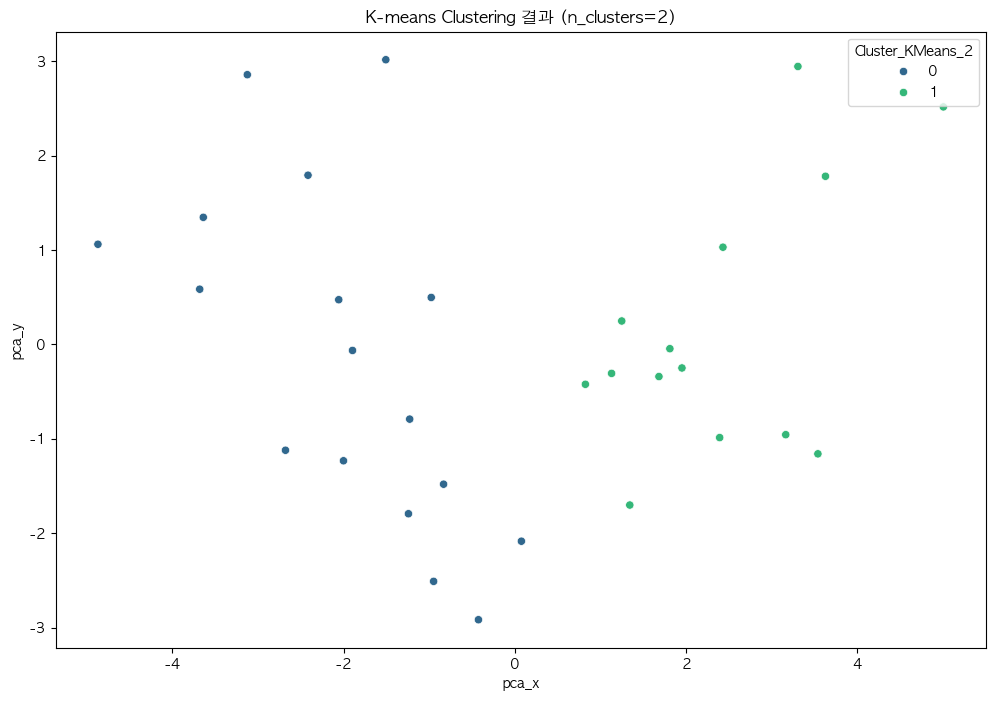


전체 실루엣 계수 (n_clusters=2): 0.32
Cluster 0의 평균 실루엣 계수: 0.34
Cluster 1의 평균 실루엣 계수: 0.30


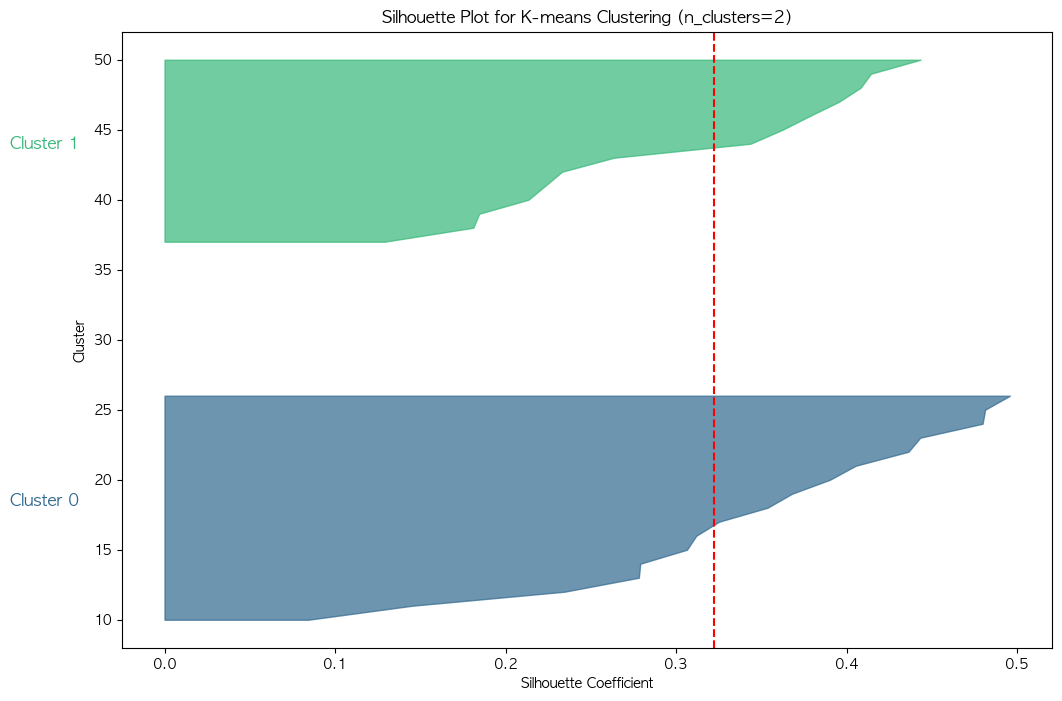

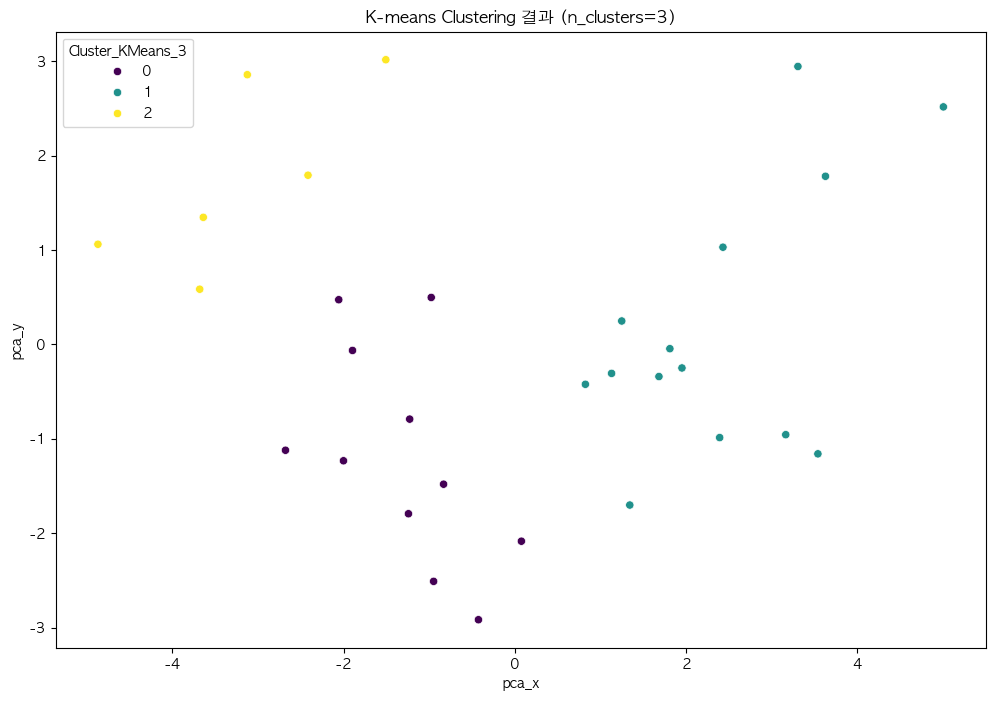


전체 실루엣 계수 (n_clusters=3): 0.26
Cluster 0의 평균 실루엣 계수: 0.34
Cluster 1의 평균 실루엣 계수: 0.20
Cluster 2의 평균 실루엣 계수: 0.25


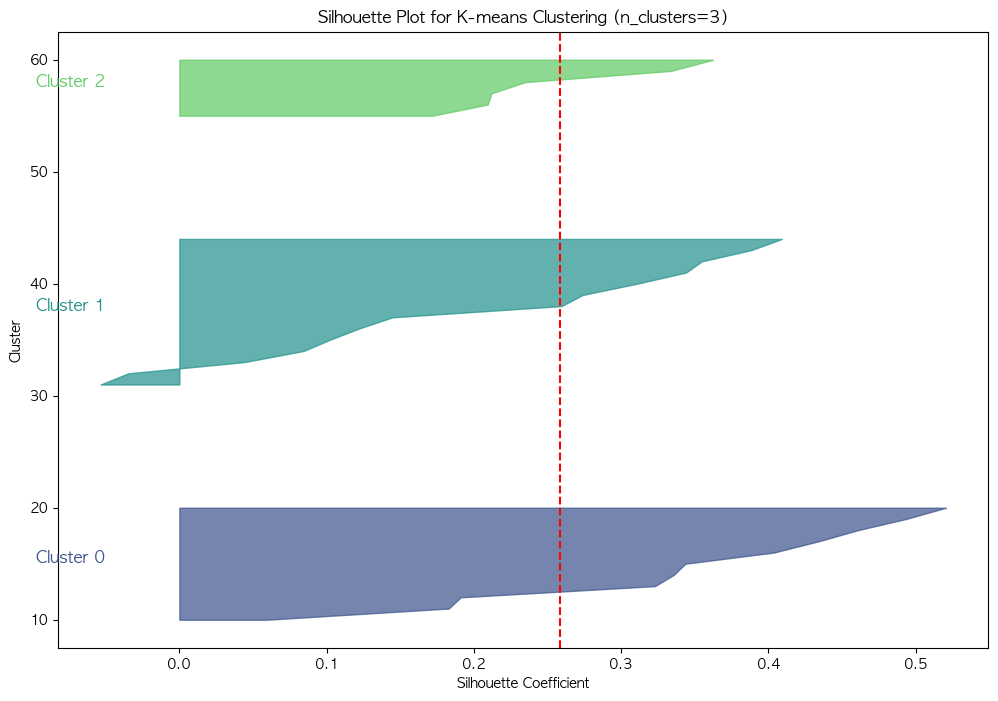

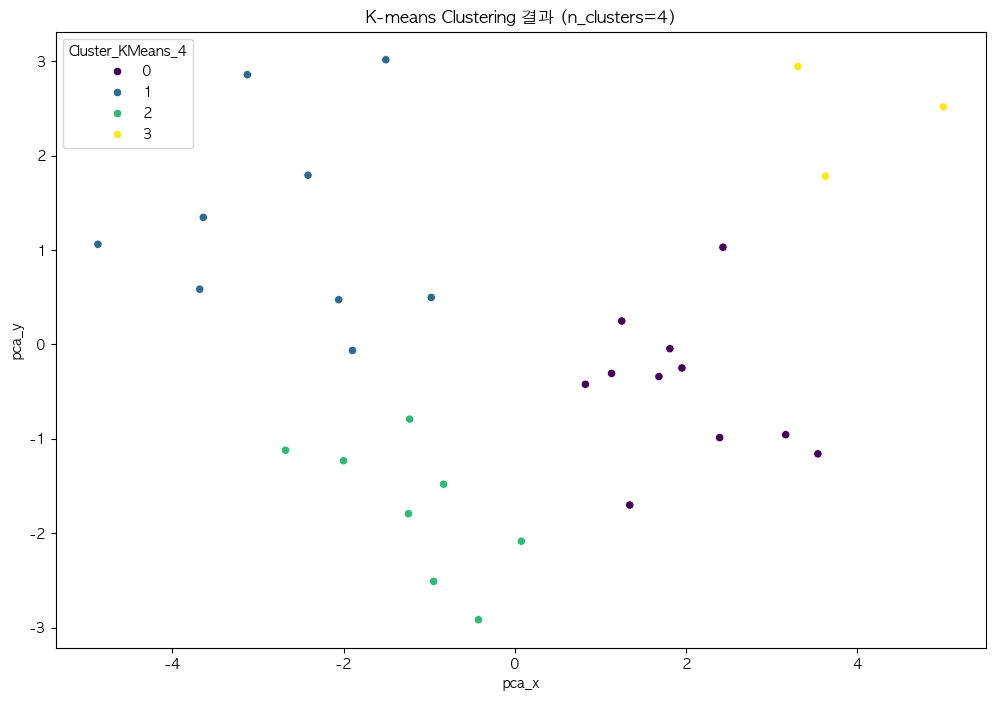


전체 실루엣 계수 (n_clusters=4): 0.26
Cluster 0의 평균 실루엣 계수: 0.14
Cluster 1의 평균 실루엣 계수: 0.21
Cluster 2의 평균 실루엣 계수: 0.37
Cluster 3의 평균 실루엣 계수: 0.50


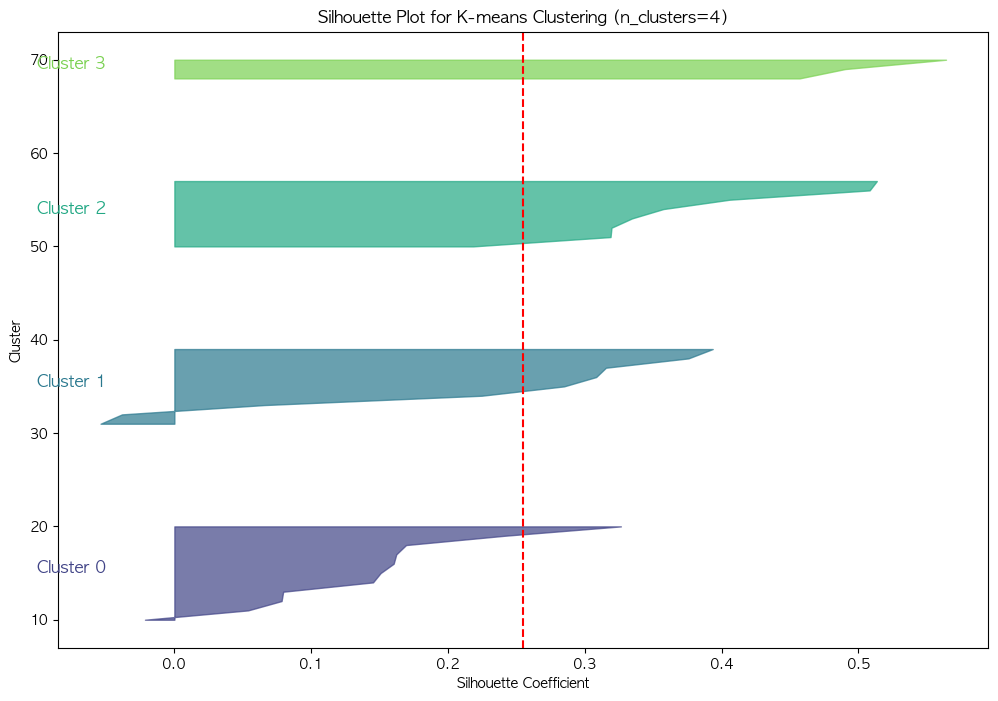

In [38]:
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score

# 한글 글꼴 설정 (macOS에서 사용 가능한 한글 글꼴)
font_path = "/System/Library/Fonts/Supplemental/AppleGothic.ttf"  # macOS에서 'AppleGothic' 글꼴을 사용합니다
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# matplotlib에서 마이너스 기호를 사용하도록 설정
plt.rcParams['axes.unicode_minus'] = False

# 필요한 칼럼 선택
features = ['결제건수', '결제금액', '총인구', '외국인 비율', '결제건수 비율', 
            '결제금액 비율', '관광객 비율', '결제취소건수 비율', '결제취소금액 비율',
            '2024개수', '2022개수', '증가분']

X = aggregated_data[features]

# 데이터 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 군집 개수 목록
n_clusters_list = [2, 3, 4]

for n_clusters in n_clusters_list:
    # K-means 군집화
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=0)
    clusters = kmeans.fit_predict(X_scaled)
    
    # 데이터에 군집 결과 추가
    aggregated_data[f'Cluster_KMeans_{n_clusters}'] = clusters
    
    # PCA를 통한 시각화
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(X_scaled)
    aggregated_data['pca_x'] = principal_components[:, 0]
    aggregated_data['pca_y'] = principal_components[:, 1]

    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='pca_x', y='pca_y', hue=f'Cluster_KMeans_{n_clusters}', data=aggregated_data, palette='viridis', legend='full')
    plt.title(f'K-means Clustering 결과 (n_clusters={n_clusters})')
    plt.show()

    # 실루엣 계수 계산
    silhouette_vals = silhouette_samples(X_scaled, clusters)
    silhouette_avg = silhouette_score(X_scaled, clusters)

    # 실루엣 계수 출력
    print(f'\n전체 실루엣 계수 (n_clusters={n_clusters}): {silhouette_avg:.2f}')
    for cluster in range(n_clusters):
        cluster_silhouette_avg = silhouette_vals[clusters == cluster].mean()
        print(f'Cluster {cluster}의 평균 실루엣 계수: {cluster_silhouette_avg:.2f}')

    # 군집별 실루엣 계수 플롯
    fig, ax = plt.subplots(figsize=(12, 8))
    y_lower = 10
    for cluster in range(n_clusters):
        cluster_silhouette_vals = silhouette_vals[clusters == cluster]
        cluster_silhouette_vals.sort()
        
        size = cluster_silhouette_vals.shape[0]
        y_upper = y_lower + size
        color = sns.color_palette('viridis', n_colors=n_clusters)[cluster]
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, facecolor=color, edgecolor=color, alpha=0.7)
        ax.text(-0.05, (y_lower + y_upper) / 2, f'Cluster {cluster}', va='center', ha='right', color=color, fontsize=12)
        y_lower = y_upper + 10

    ax.axvline(x=np.mean(silhouette_vals), color='red', linestyle='--')
    ax.set_xlabel('Silhouette Coefficient')
    ax.set_ylabel('Cluster')
    ax.set_title(f'Silhouette Plot for K-means Clustering (n_clusters={n_clusters})')
    plt.show()

# DBSCAN

In [39]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import numpy as np

# 필요한 칼럼 선택
features = ['결제건수', '결제금액', '총인구', '외국인 비율', '결제건수 비율', 
            '결제금액 비율', '관광객 비율', '결제취소건수 비율', '결제취소금액 비율',
            '2024개수', '2022개수', '증가분']

X = aggregated_data[features]

# 데이터 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 하이퍼파라미터 최적화
eps_values = np.arange(0.1, 1.1, 0.1)
min_samples_values = range(2, 10)

best_eps = 0
best_min_samples = 0
best_silhouette = -1

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(X_scaled)
        
        # 클러스터가 하나만 있는 경우 silhouette_score를 계산하지 않음
        if len(set(clusters)) > 1:
            silhouette_avg = silhouette_score(X_scaled, clusters)
            if silhouette_avg > best_silhouette:
                best_silhouette = silhouette_avg
                best_eps = eps
                best_min_samples = min_samples

print(f"Best eps: {best_eps}")
print(f"Best min_samples: {best_min_samples}")
print(f"Best Silhouette Score: {best_silhouette}")

Best eps: 1.0
Best min_samples: 2
Best Silhouette Score: -0.1640116276815348


Best eps: 2.0
Best min_samples: 2
Best Silhouette Score: 0.01993487938382963


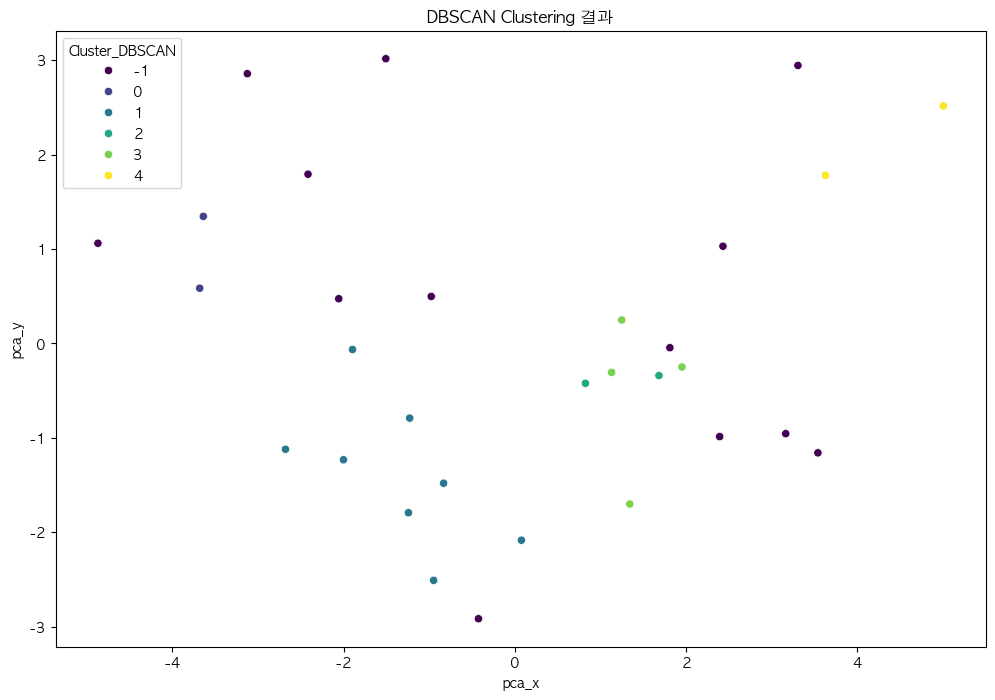


전체 실루엣 계수: 0.02
Cluster 0의 평균 실루엣 계수: 0.68
Cluster 1의 평균 실루엣 계수: 0.19
Cluster 2의 평균 실루엣 계수: 0.30
Cluster 3의 평균 실루엣 계수: 0.40
Cluster 4의 평균 실루엣 계수: 0.52


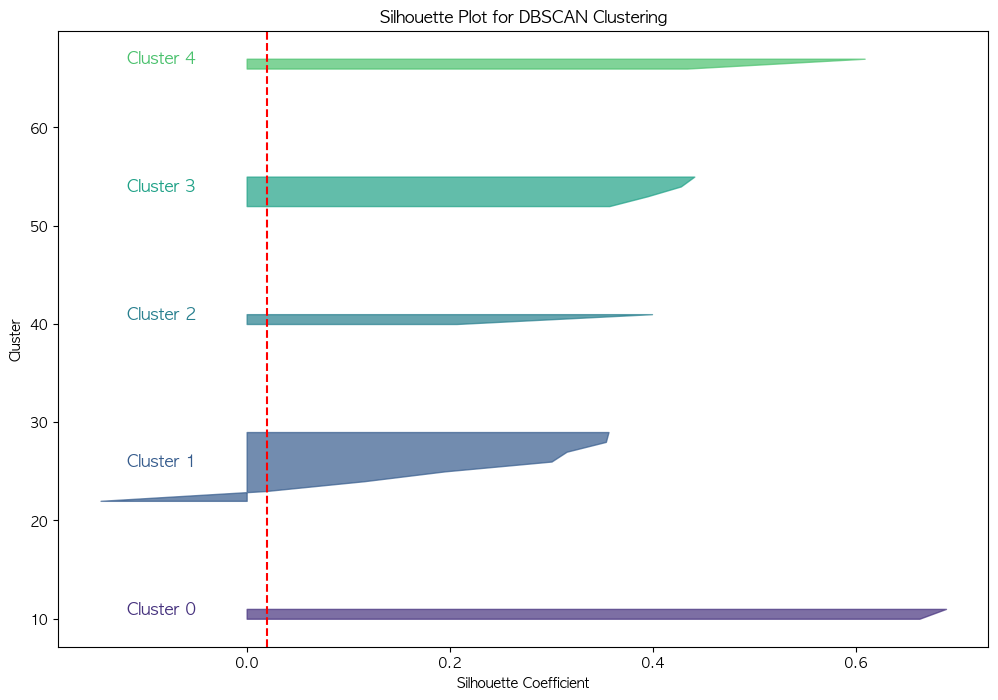

In [46]:
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np
import pandas as pd

# 한글 글꼴 설정 (macOS에서 사용 가능한 한글 글꼴)
font_path = "/System/Library/Fonts/Supplemental/AppleGothic.ttf"  # macOS에서 'AppleGothic' 글꼴을 사용합니다
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# matplotlib에서 마이너스 기호를 사용하도록 설정
plt.rcParams['axes.unicode_minus'] = False

# 데이터 준비
features = ['결제건수', '결제금액', '총인구', '외국인 비율', '결제건수 비율', 
            '결제금액 비율', '관광객 비율', '결제취소건수 비율', '결제취소금액 비율',
            '2024개수', '2022개수', '증가분']
X = aggregated_data[features]

# 데이터 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 하이퍼파라미터 최적화
eps_values = np.arange(0.1, 2.1, 0.1)  # eps 값을 0.1 이상으로 설정
min_samples_values = range(2, 10)

best_eps = None
best_min_samples = None
best_silhouette = -1

for eps in eps_values:
    for min_samples in min_samples_values:
        if eps <= 0:
            continue  # eps가 0 이하일 경우 skip

        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(X_scaled)
        
        # 클러스터의 수가 2 이상 5 이하인지 확인
        num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
        if 2 <= num_clusters <= 5:
            if len(set(clusters)) > 1 and -1 in clusters and len(set(clusters) - {-1}) > 1:
                try:
                    silhouette_avg = silhouette_score(X_scaled, clusters)
                    if silhouette_avg > best_silhouette:
                        best_silhouette = silhouette_avg
                        best_eps = eps
                        best_min_samples = min_samples
                except:
                    continue  # 실루엣 계수를 계산할 수 없는 경우 skip

print(f"Best eps: {best_eps}")
print(f"Best min_samples: {best_min_samples}")
print(f"Best Silhouette Score: {best_silhouette}")

# 최적의 하이퍼파라미터로 DBSCAN 군집화
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
clusters = dbscan.fit_predict(X_scaled)

# 데이터에 군집 결과 추가
aggregated_data['Cluster_DBSCAN'] = clusters

# PCA를 통한 시각화
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)
aggregated_data['pca_x'] = principal_components[:, 0]
aggregated_data['pca_y'] = principal_components[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(x='pca_x', y='pca_y', hue='Cluster_DBSCAN', data=aggregated_data, palette='viridis', legend='full')
plt.title('DBSCAN Clustering 결과')
plt.show()

# 클러스터의 수가 2 이상 5 이하인지 확인 후 실루엣 계수 계산
num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
if 2 <= num_clusters <= 5:
    # 실루엣 계수 계산
    silhouette_vals = silhouette_samples(X_scaled, clusters)
    silhouette_avg = silhouette_score(X_scaled, clusters)

    # 실루엣 계수 출력
    print(f'\n전체 실루엣 계수: {silhouette_avg:.2f}')
    for cluster in set(clusters):
        if cluster != -1:
            cluster_silhouette_avg = silhouette_vals[clusters == cluster].mean()
            print(f'Cluster {cluster}의 평균 실루엣 계수: {cluster_silhouette_avg:.2f}')

    # 군집별 실루엣 계수 플롯
    fig, ax = plt.subplots(figsize=(12, 8))
    y_lower = 10
    for cluster in set(clusters):
        if cluster != -1:
            cluster_silhouette_vals = silhouette_vals[clusters == cluster]
            cluster_silhouette_vals.sort()
            
            size = cluster_silhouette_vals.shape[0]
            y_upper = y_lower + size
            color = sns.color_palette('viridis', n_colors=len(set(clusters)))[cluster]
            ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, facecolor=color, edgecolor=color, alpha=0.7)
            ax.text(-0.05, (y_lower + y_upper) / 2, f'Cluster {cluster}', va='center', ha='right', color=color, fontsize=12)
            y_lower = y_upper + 10

    ax.axvline(x=np.mean(silhouette_vals), color='red', linestyle='--')
    ax.set_xlabel('Silhouette Coefficient')
    ax.set_ylabel('Cluster')
    ax.set_title('Silhouette Plot for DBSCAN Clustering')
    plt.show()
else:
    print("클러스터의 수가 2에서 5 사이가 아니므로 실루엣 계수를 계산하지 않습니다.")

# 계층적 군집화

/Users/heohyeonjun/anaconda3/envs/tf29_py39/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


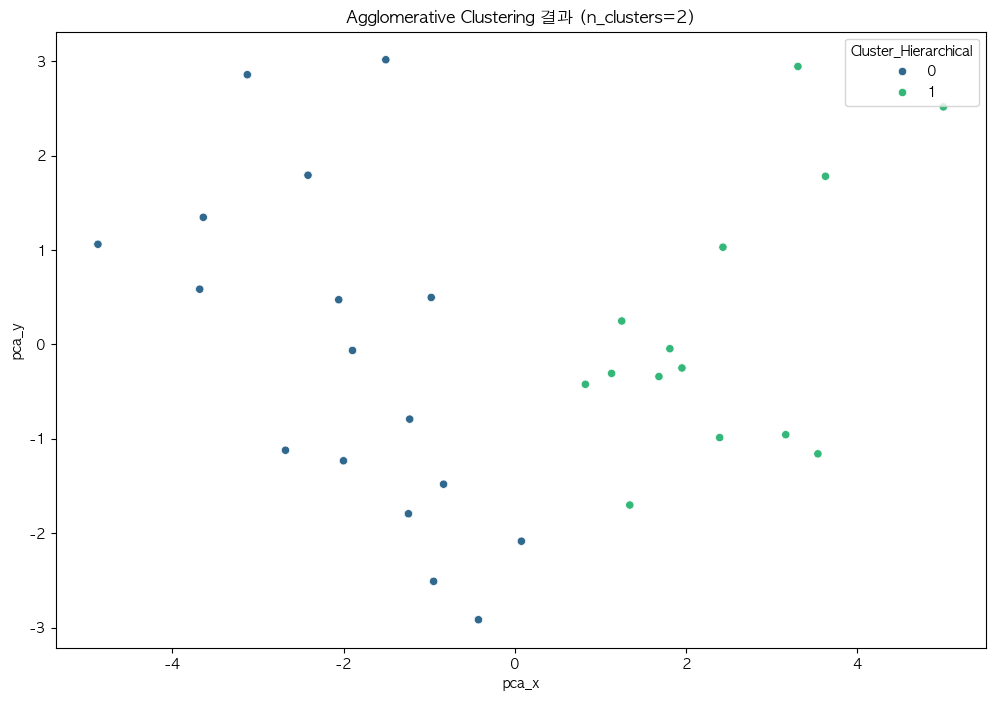

/Users/heohyeonjun/anaconda3/envs/tf29_py39/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


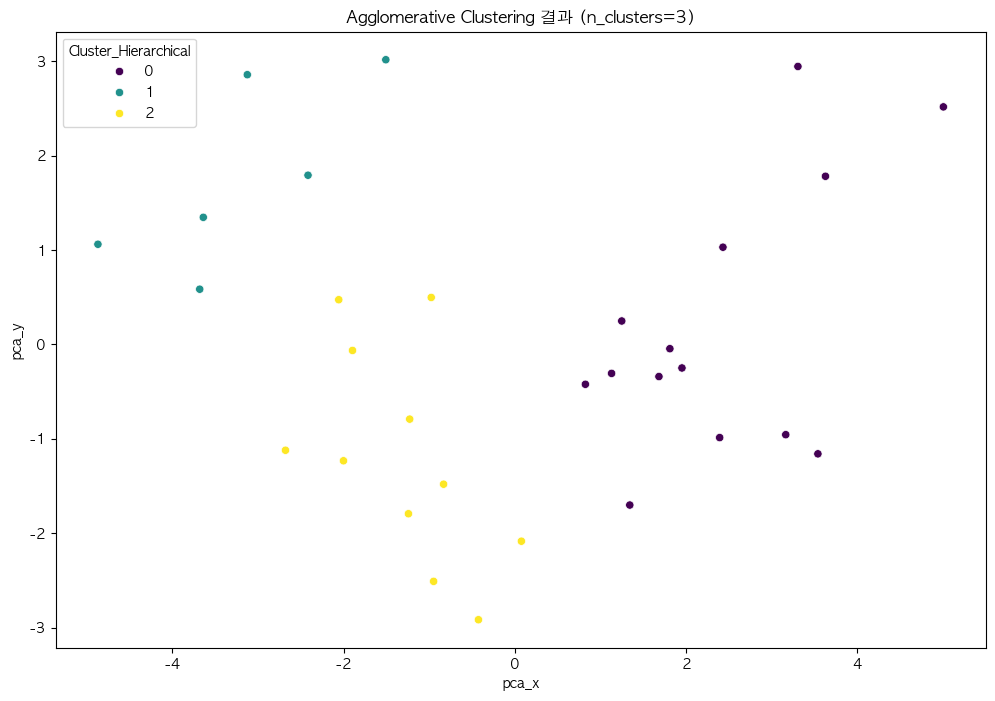

/Users/heohyeonjun/anaconda3/envs/tf29_py39/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


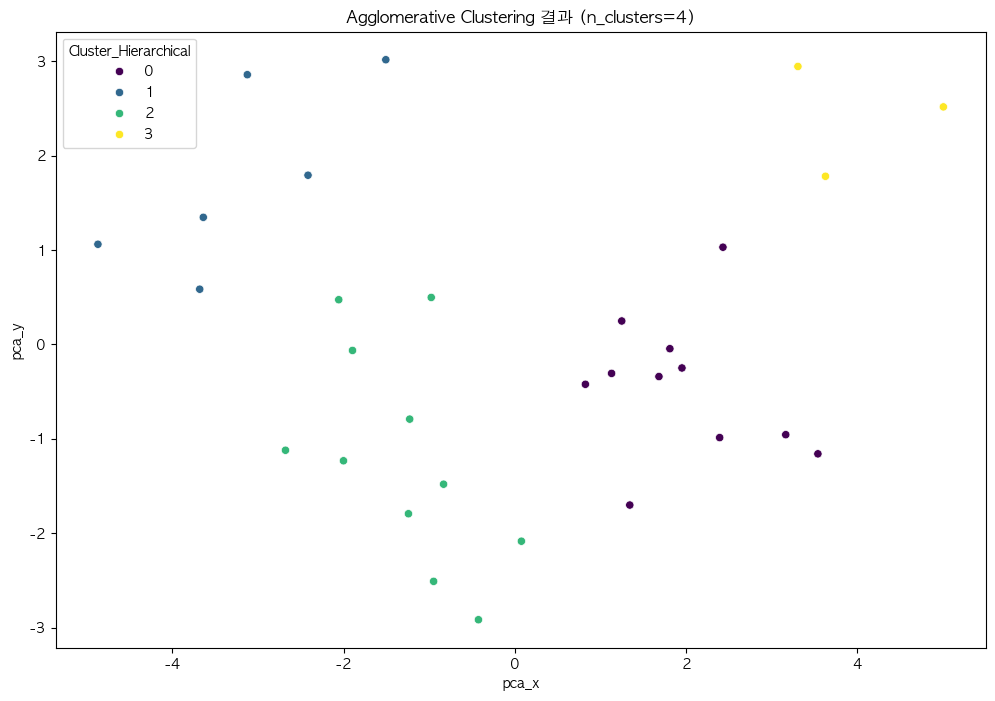

In [47]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Agglomerative Clustering
for n_clusters in range(2, 5):
    hierarchical = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
    clusters = hierarchical.fit_predict(X_scaled)
    
    # 결과를 데이터프레임에 추가
    aggregated_data['Cluster_Hierarchical'] = clusters

    # PCA를 통한 시각화
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(X_scaled)
    aggregated_data['pca_x'] = principal_components[:, 0]
    aggregated_data['pca_y'] = principal_components[:, 1]

    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='pca_x', y='pca_y', hue='Cluster_Hierarchical', data=aggregated_data, palette='viridis', legend='full')
    plt.title(f'Agglomerative Clustering 결과 (n_clusters={n_clusters})')
    plt.show()

# GMM

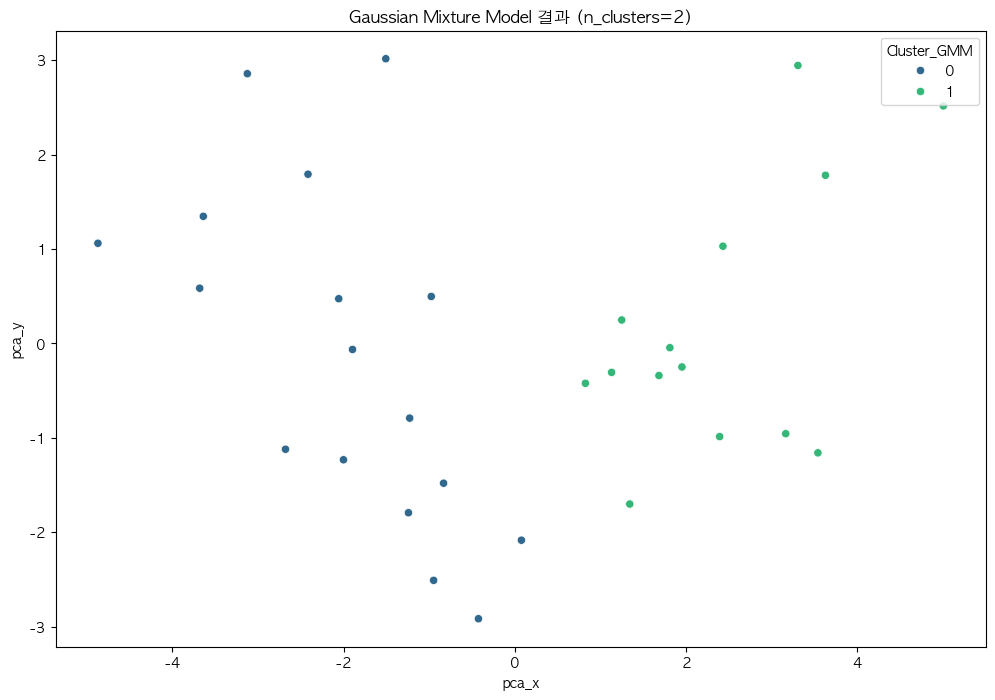

GMM - n_clusters=2, 실루엣 계수: 0.32


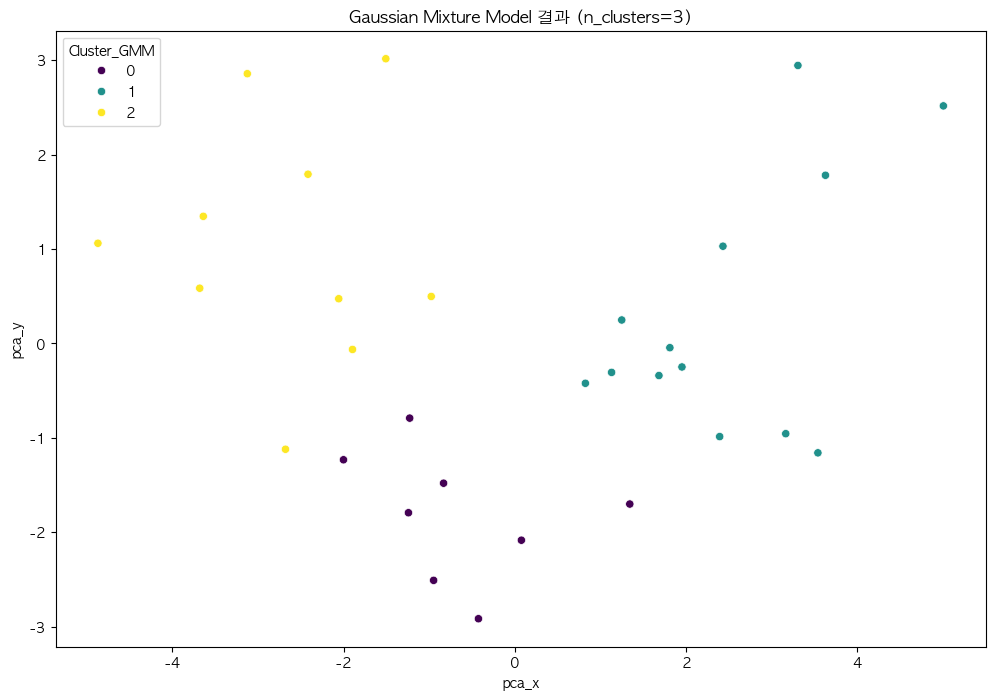

GMM - n_clusters=3, 실루엣 계수: 0.23


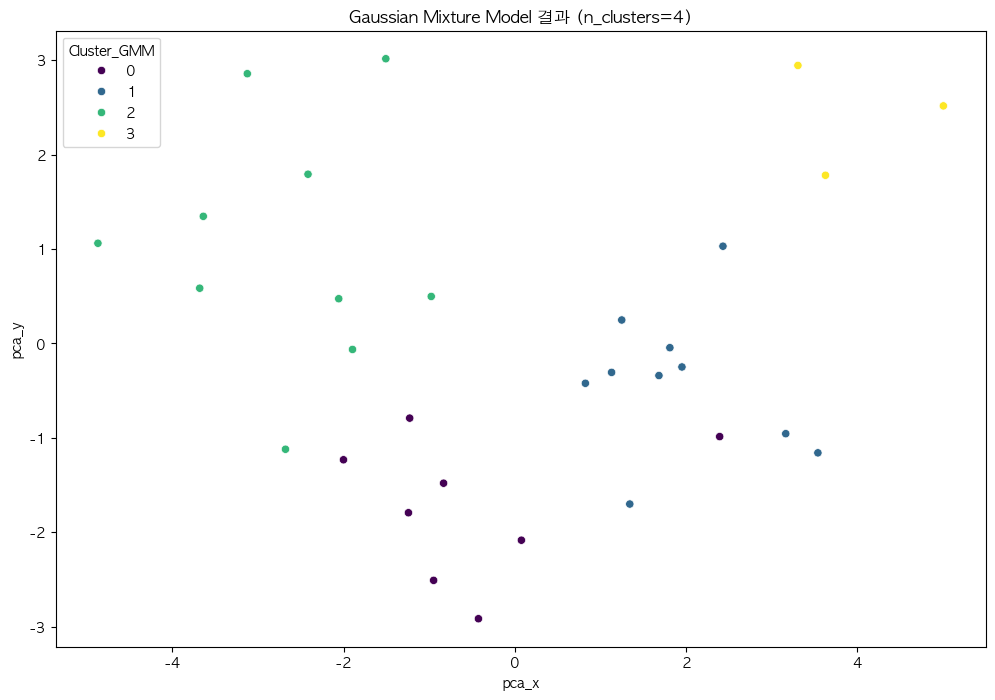

GMM - n_clusters=4, 실루엣 계수: 0.25


In [48]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

for n_clusters in range(2, 5):
    gmm = GaussianMixture(n_components=n_clusters, random_state=0)
    clusters = gmm.fit_predict(X_scaled)
    
    # 결과를 데이터프레임에 추가
    aggregated_data['Cluster_GMM'] = clusters

    # PCA를 통한 시각화
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(X_scaled)
    aggregated_data['pca_x'] = principal_components[:, 0]
    aggregated_data['pca_y'] = principal_components[:, 1]

    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='pca_x', y='pca_y', hue='Cluster_GMM', data=aggregated_data, palette='viridis', legend='full')
    plt.title(f'Gaussian Mixture Model 결과 (n_clusters={n_clusters})')
    plt.show()

    # 실루엣 계수 계산
    silhouette_avg = silhouette_score(X_scaled, clusters)
    print(f'GMM - n_clusters={n_clusters}, 실루엣 계수: {silhouette_avg:.2f}')

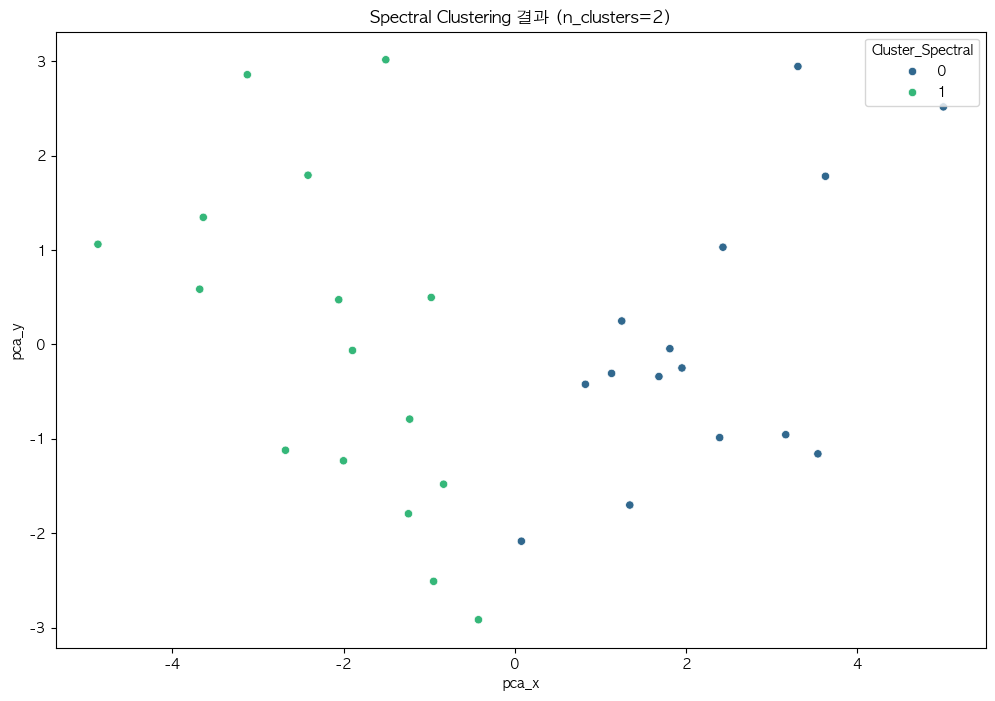

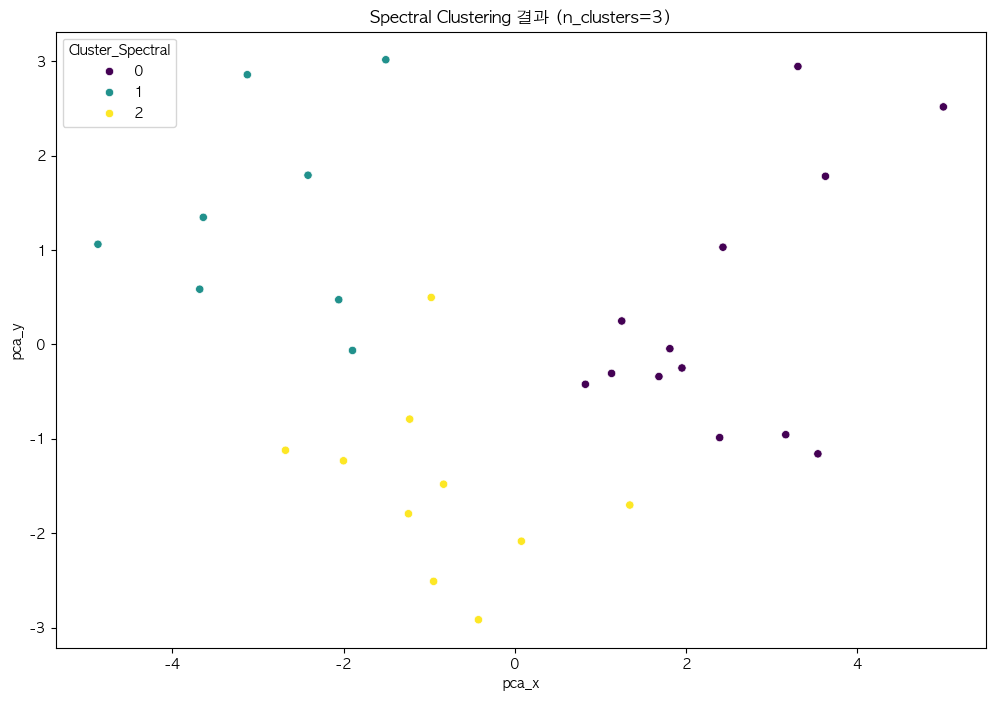

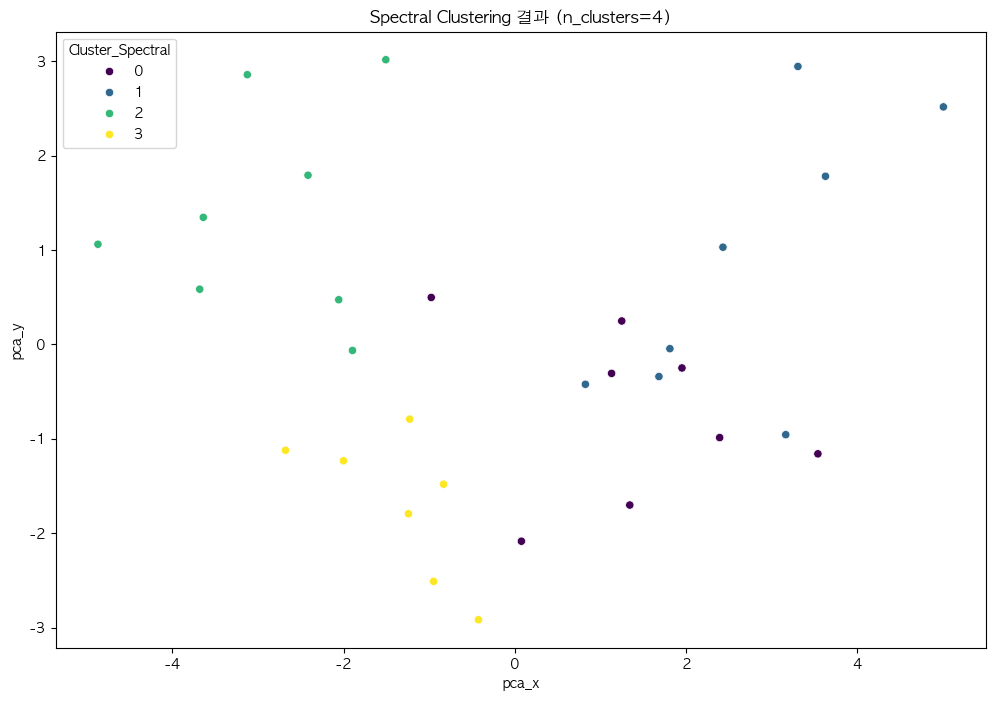

In [49]:
from sklearn.cluster import SpectralClustering

for n_clusters in range(2, 5):
    spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=0)
    clusters = spectral.fit_predict(X_scaled)
    
    # 결과를 데이터프레임에 추가
    aggregated_data['Cluster_Spectral'] = clusters

    # PCA를 통한 시각화
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(X_scaled)
    aggregated_data['pca_x'] = principal_components[:, 0]
    aggregated_data['pca_y'] = principal_components[:, 1]

    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='pca_x', y='pca_y', hue='Cluster_Spectral', data=aggregated_data, palette='viridis', legend='full')
    plt.title(f'Spectral Clustering 결과 (n_clusters={n_clusters})')
    plt.show()

# K-means 최종


K-means 군집화 결과 (n_clusters=2):
Cluster 0: 가평군, 과천시, 광명시, 광주시, 구리시, 군포시, 동두천시, 안성시, 양주시, 양평군, 여주시, 연천군, 오산시, 의왕시, 이천시, 포천시, 하남시
Cluster 1: 고양시, 김포시, 남양주시, 부천시, 성남시, 수원시, 시흥시, 안산시, 안양시, 용인시, 의정부시, 파주시, 평택시, 화성시


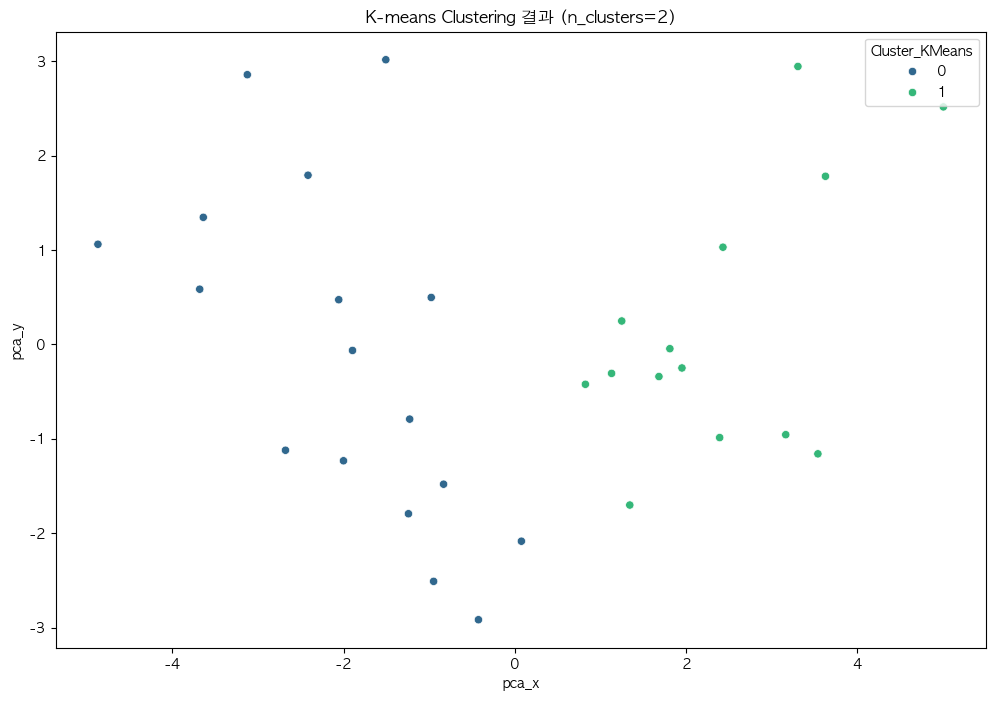

K-means - n_clusters=2, 실루엣 계수: 0.32

K-means 군집화 결과 (n_clusters=3):
Cluster 0: 광명시, 구리시, 동두천시, 안성시, 양주시, 여주시, 연천군, 오산시, 의왕시, 이천시, 포천시
Cluster 1: 고양시, 김포시, 남양주시, 부천시, 성남시, 수원시, 시흥시, 안산시, 안양시, 용인시, 의정부시, 파주시, 평택시, 화성시
Cluster 2: 가평군, 과천시, 광주시, 군포시, 양평군, 하남시


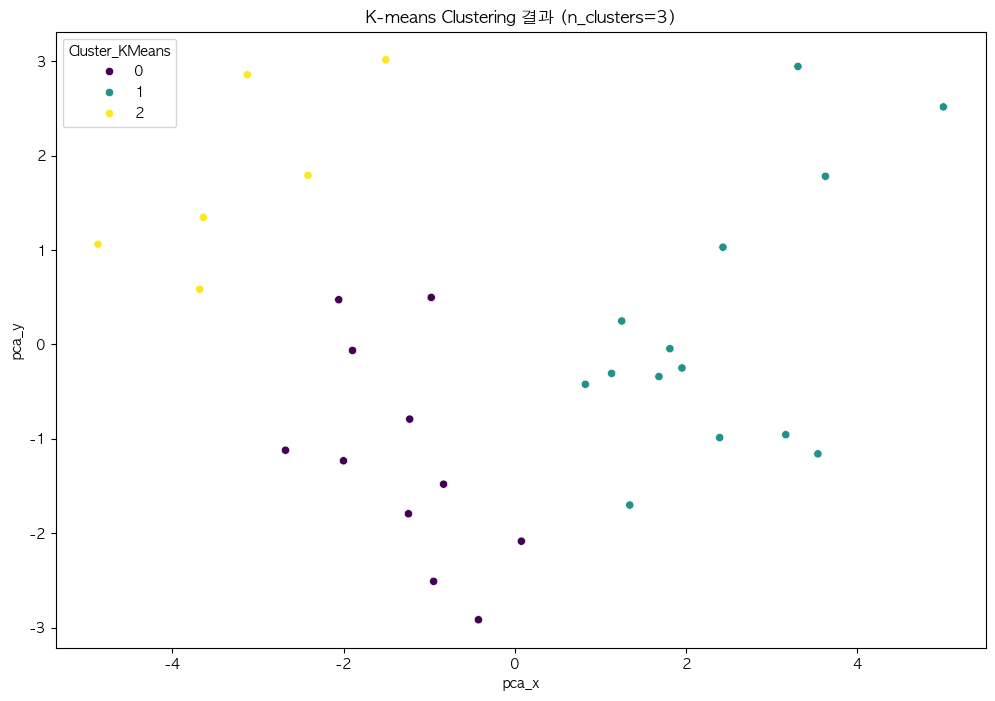

K-means - n_clusters=3, 실루엣 계수: 0.26

K-means 군집화 결과 (n_clusters=4):
Cluster 0: 고양시, 김포시, 남양주시, 부천시, 성남시, 시흥시, 안산시, 안양시, 의정부시, 파주시, 평택시
Cluster 1: 가평군, 과천시, 광명시, 광주시, 구리시, 군포시, 양평군, 이천시, 하남시
Cluster 2: 동두천시, 안성시, 양주시, 여주시, 연천군, 오산시, 의왕시, 포천시
Cluster 3: 수원시, 용인시, 화성시


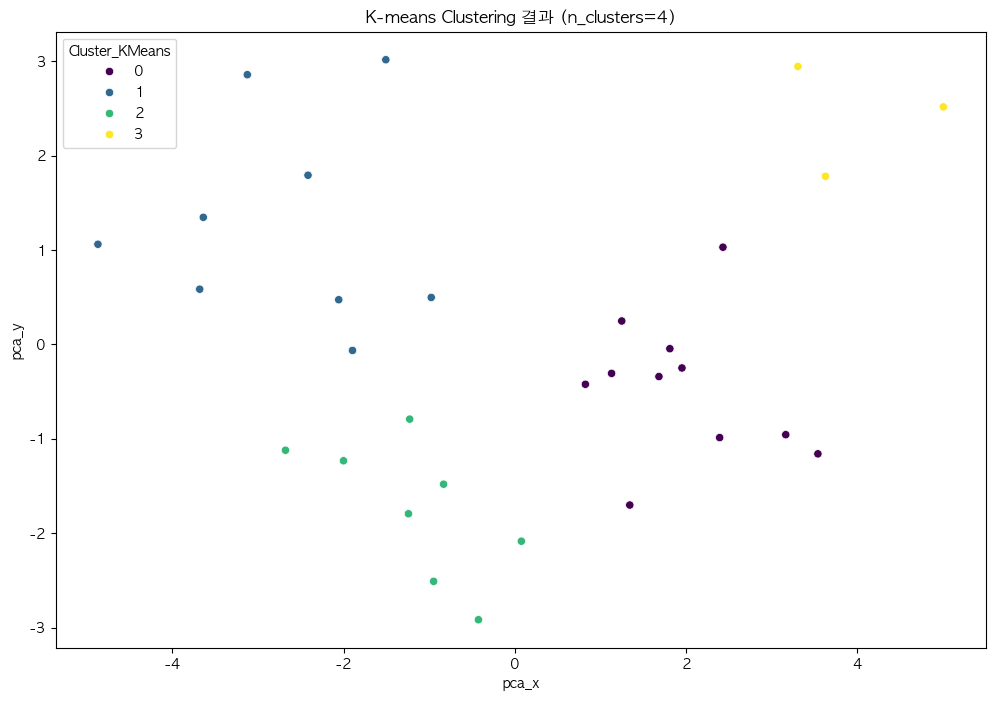

K-means - n_clusters=4, 실루엣 계수: 0.26


In [50]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd

# 데이터 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(aggregated_data[features])

# K-means 군집화 및 출력
for n_clusters in range(2, 5):
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=0)
    clusters = kmeans.fit_predict(X_scaled)
    
    # 데이터프레임에 군집 결과 추가
    aggregated_data['Cluster_KMeans'] = clusters
    
    # 각 군집에 속한 시군명 출력
    print(f"\nK-means 군집화 결과 (n_clusters={n_clusters}):")
    cluster_groups = aggregated_data.groupby('Cluster_KMeans')['시군명'].apply(list)
    for cluster, cities in cluster_groups.items():
        print(f"Cluster {cluster}: {', '.join(cities)}")

    # PCA를 통한 시각화
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(X_scaled)
    aggregated_data['pca_x'] = principal_components[:, 0]
    aggregated_data['pca_y'] = principal_components[:, 1]

    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='pca_x', y='pca_y', hue='Cluster_KMeans', data=aggregated_data, palette='viridis', legend='full')
    plt.title(f'K-means Clustering 결과 (n_clusters={n_clusters})')
    plt.show()

    # 실루엣 계수 계산
    silhouette_avg = silhouette_score(X_scaled, clusters)
    print(f'K-means - n_clusters={n_clusters}, 실루엣 계수: {silhouette_avg:.2f}')

# Hierarchical Clustering (계층적 군집화) - 최종


Agglomerative Clustering 결과 (n_clusters=2):
Cluster 0: 가평군, 과천시, 광명시, 광주시, 구리시, 군포시, 동두천시, 안성시, 양주시, 양평군, 여주시, 연천군, 오산시, 의왕시, 이천시, 포천시, 하남시
Cluster 1: 고양시, 김포시, 남양주시, 부천시, 성남시, 수원시, 시흥시, 안산시, 안양시, 용인시, 의정부시, 파주시, 평택시, 화성시


/Users/heohyeonjun/anaconda3/envs/tf29_py39/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


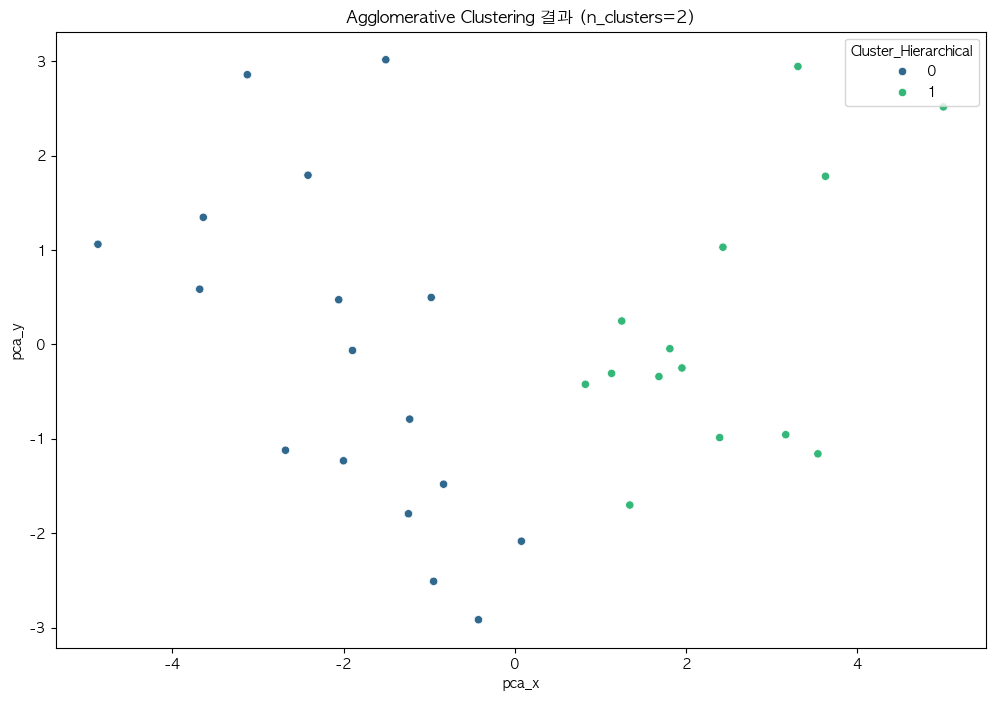


Agglomerative Clustering 결과 (n_clusters=3):
Cluster 0: 고양시, 김포시, 남양주시, 부천시, 성남시, 수원시, 시흥시, 안산시, 안양시, 용인시, 의정부시, 파주시, 평택시, 화성시
Cluster 1: 가평군, 과천시, 광주시, 군포시, 양평군, 하남시
Cluster 2: 광명시, 구리시, 동두천시, 안성시, 양주시, 여주시, 연천군, 오산시, 의왕시, 이천시, 포천시


/Users/heohyeonjun/anaconda3/envs/tf29_py39/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


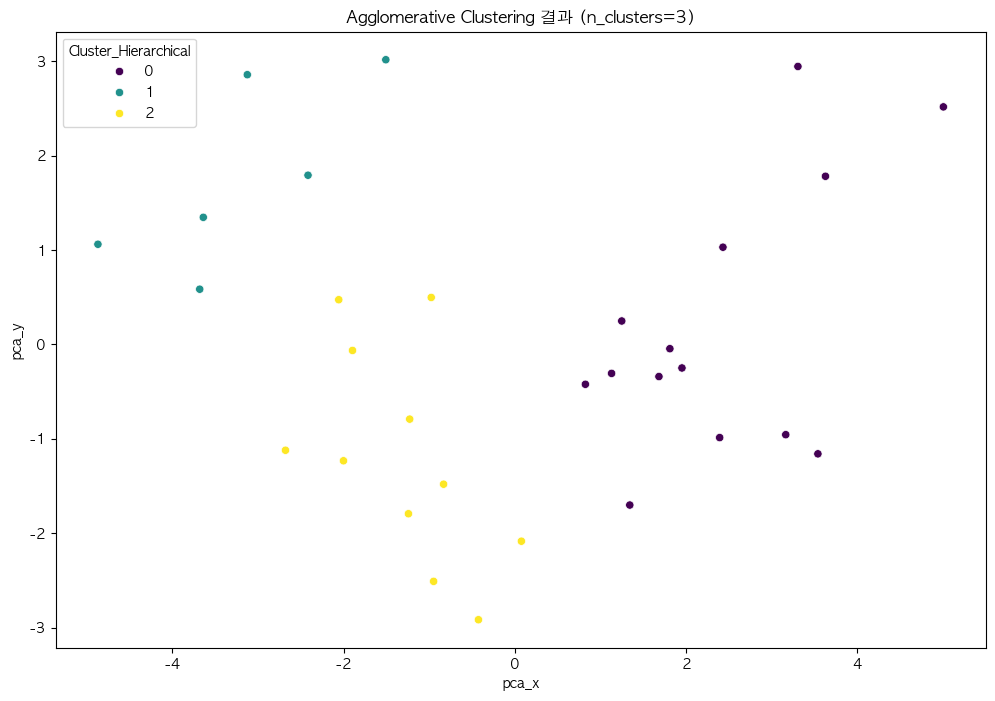


Agglomerative Clustering 결과 (n_clusters=4):
Cluster 0: 고양시, 김포시, 남양주시, 부천시, 성남시, 시흥시, 안산시, 안양시, 의정부시, 파주시, 평택시
Cluster 1: 가평군, 과천시, 광주시, 군포시, 양평군, 하남시
Cluster 2: 광명시, 구리시, 동두천시, 안성시, 양주시, 여주시, 연천군, 오산시, 의왕시, 이천시, 포천시
Cluster 3: 수원시, 용인시, 화성시


/Users/heohyeonjun/anaconda3/envs/tf29_py39/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


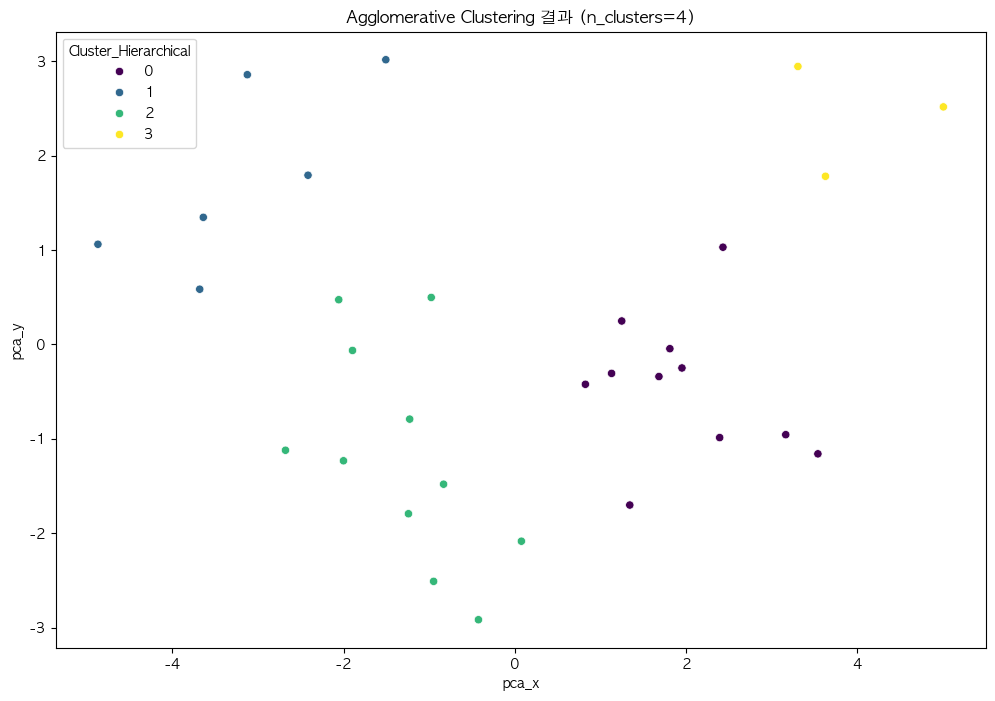

In [51]:
from sklearn.cluster import AgglomerativeClustering

# 계층적 군집화 및 출력
for n_clusters in range(2, 5):
    hierarchical = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
    clusters = hierarchical.fit_predict(X_scaled)
    
    # 데이터프레임에 군집 결과 추가
    aggregated_data['Cluster_Hierarchical'] = clusters
    
    # 각 군집에 속한 시군명 출력
    print(f"\nAgglomerative Clustering 결과 (n_clusters={n_clusters}):")
    cluster_groups = aggregated_data.groupby('Cluster_Hierarchical')['시군명'].apply(list)
    for cluster, cities in cluster_groups.items():
        print(f"Cluster {cluster}: {', '.join(cities)}")

    # PCA를 통한 시각화
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(X_scaled)
    aggregated_data['pca_x'] = principal_components[:, 0]
    aggregated_data['pca_y'] = principal_components[:, 1]

    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='pca_x', y='pca_y', hue='Cluster_Hierarchical', data=aggregated_data, palette='viridis', legend='full')
    plt.title(f'Agglomerative Clustering 결과 (n_clusters={n_clusters})')
    plt.show()

# Gaussian Mixture Models (GMM)


Gaussian Mixture Model 결과 (n_clusters=2):
Cluster 0: 가평군, 과천시, 광명시, 광주시, 구리시, 군포시, 동두천시, 안성시, 양주시, 양평군, 여주시, 연천군, 오산시, 의왕시, 이천시, 포천시, 하남시
Cluster 1: 고양시, 김포시, 남양주시, 부천시, 성남시, 수원시, 시흥시, 안산시, 안양시, 용인시, 의정부시, 파주시, 평택시, 화성시


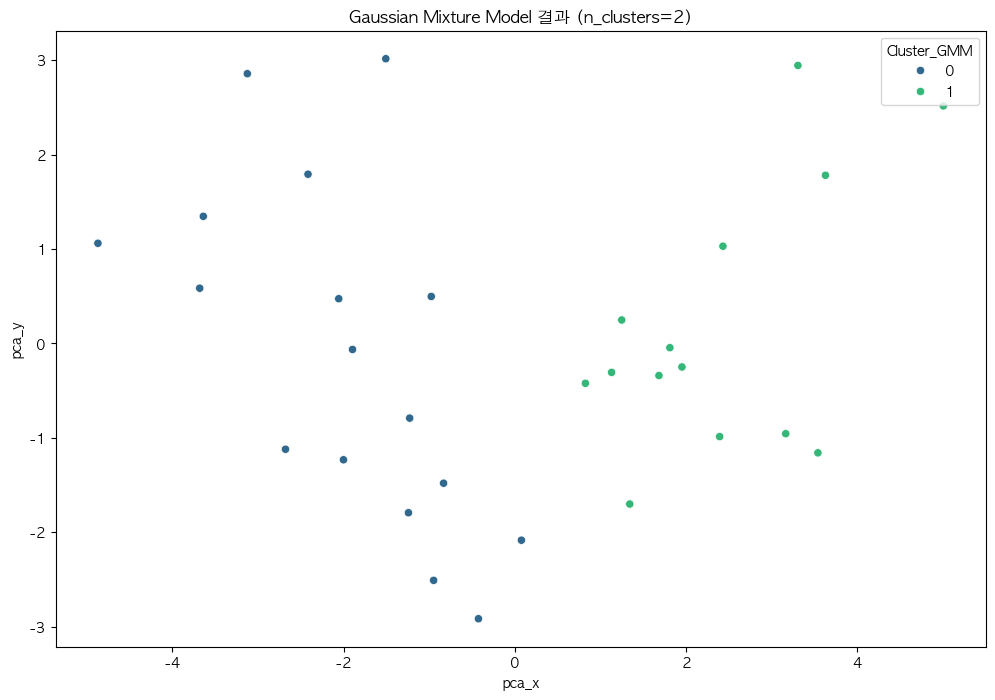

GMM - n_clusters=2, 실루엣 계수: 0.32

Gaussian Mixture Model 결과 (n_clusters=3):
Cluster 0: 동두천시, 안성시, 양주시, 여주시, 오산시, 의왕시, 의정부시, 포천시
Cluster 1: 고양시, 김포시, 남양주시, 부천시, 성남시, 수원시, 시흥시, 안산시, 안양시, 용인시, 파주시, 평택시, 화성시
Cluster 2: 가평군, 과천시, 광명시, 광주시, 구리시, 군포시, 양평군, 연천군, 이천시, 하남시


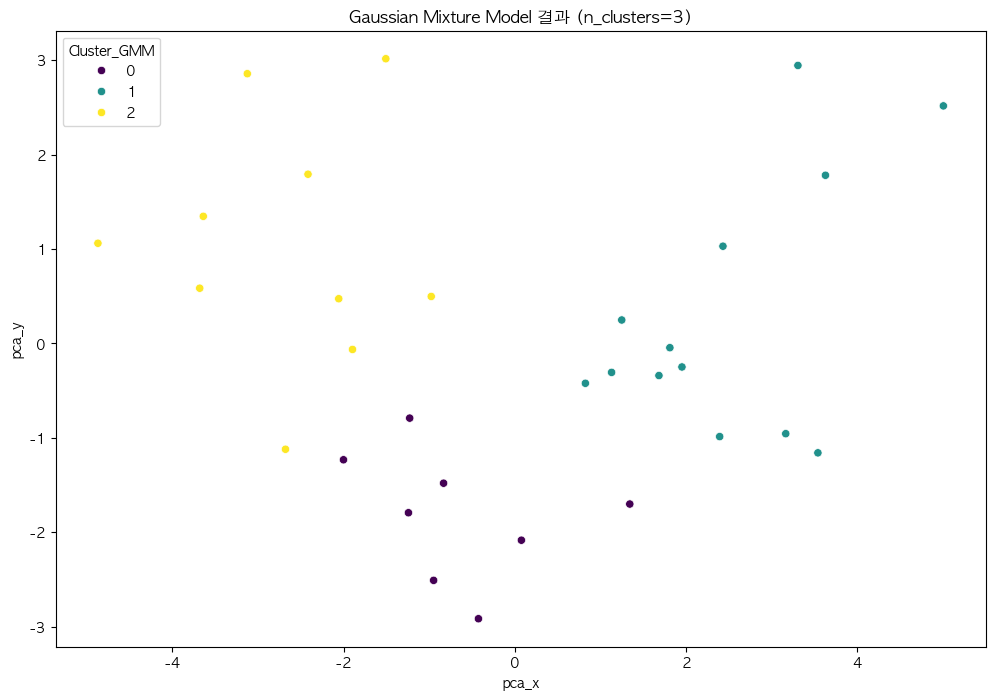

GMM - n_clusters=3, 실루엣 계수: 0.23

Gaussian Mixture Model 결과 (n_clusters=4):
Cluster 0: 동두천시, 안성시, 양주시, 여주시, 오산시, 의왕시, 평택시, 포천시
Cluster 1: 고양시, 김포시, 남양주시, 부천시, 성남시, 시흥시, 안산시, 안양시, 의정부시, 파주시
Cluster 2: 가평군, 과천시, 광명시, 광주시, 구리시, 군포시, 양평군, 연천군, 이천시, 하남시
Cluster 3: 수원시, 용인시, 화성시


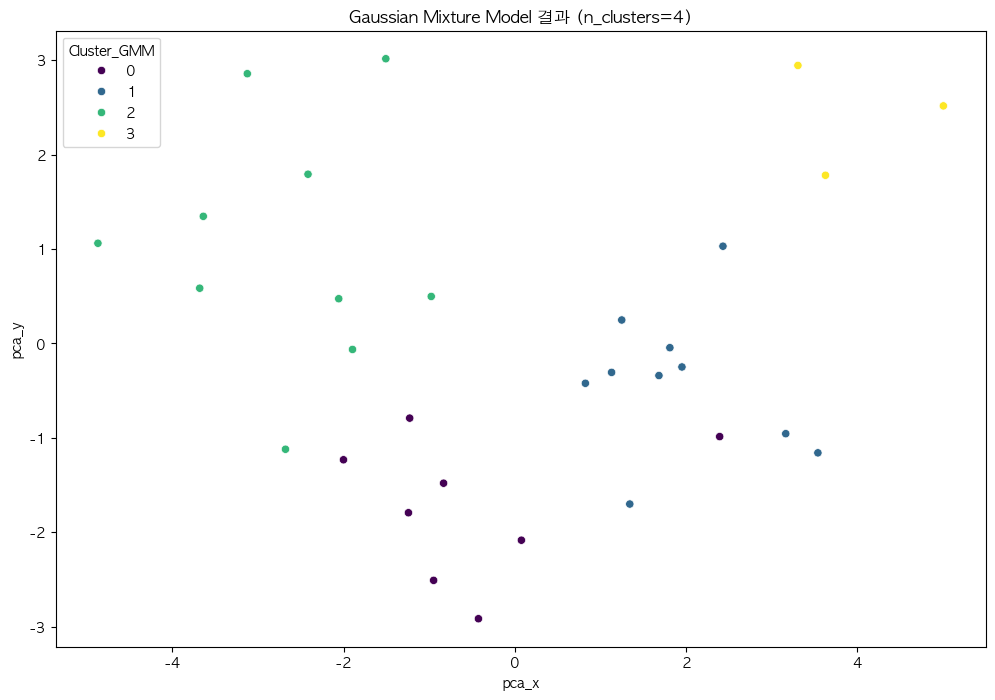

GMM - n_clusters=4, 실루엣 계수: 0.25


In [52]:
from sklearn.mixture import GaussianMixture

# GMM 군집화 및 출력
for n_clusters in range(2, 5):
    gmm = GaussianMixture(n_components=n_clusters, random_state=0)
    clusters = gmm.fit_predict(X_scaled)
    
    # 데이터프레임에 군집 결과 추가
    aggregated_data['Cluster_GMM'] = clusters
    
    # 각 군집에 속한 시군명 출력
    print(f"\nGaussian Mixture Model 결과 (n_clusters={n_clusters}):")
    cluster_groups = aggregated_data.groupby('Cluster_GMM')['시군명'].apply(list)
    for cluster, cities in cluster_groups.items():
        print(f"Cluster {cluster}: {', '.join(cities)}")

    # PCA를 통한 시각화
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(X_scaled)
    aggregated_data['pca_x'] = principal_components[:, 0]
    aggregated_data['pca_y'] = principal_components[:, 1]

    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='pca_x', y='pca_y', hue='Cluster_GMM', data=aggregated_data, palette='viridis', legend='full')
    plt.title(f'Gaussian Mixture Model 결과 (n_clusters={n_clusters})')
    plt.show()

    # 실루엣 계수 계산
    silhouette_avg = silhouette_score(X_scaled, clusters)
    print(f'GMM - n_clusters={n_clusters}, 실루엣 계수: {silhouette_avg:.2f}')